In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression,Lasso,Ridge
from sklearn.metrics import confusion_matrix,roc_curve,precision_score,recall_score,f1_score,roc_auc_score
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import  PCA

In [2]:
insurance_df = pd.read_csv("insurance_claims.csv")
insurance_df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,6/9/2000,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,6/6/2014,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,16-07-1991,OH,500/1000,1000,1310.80,0,431289,...,1,?,87200,17440,8720,61040,Honda,Accord,2006,N
996,285,41,186934,5/1/2014,IL,100/300,1000,1436.79,0,608177,...,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N
997,130,34,918516,17-02-2003,OH,250/500,500,1383.49,3000000,442797,...,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N
998,458,62,533940,18-11-2011,IL,500/1000,2000,1356.92,5000000,441714,...,1,YES,46980,5220,5220,36540,Audi,A5,1998,N


In [4]:
#insurance_df.replace({'Y':1,'N':0},inplace = True)
#insurance_df

In [5]:
insurance_df["fraud_reported"].dtype

dtype('O')

In [3]:
cat_cols = []
con_cols = []
for col in insurance_df.columns:
    if insurance_df[col].dtype =='object':
        cat_cols.append(col)
    else:
        con_cols.append(col)
cat_cols
con_cols

['months_as_customer',
 'age',
 'policy_number',
 'policy_deductable',
 'policy_annual_premium',
 'umbrella_limit',
 'insured_zip',
 'capital-gains',
 'capital-loss',
 'incident_hour_of_the_day',
 'number_of_vehicles_involved',
 'bodily_injuries',
 'witnesses',
 'total_claim_amount',
 'injury_claim',
 'property_claim',
 'vehicle_claim',
 'auto_year']

# finding correlated columns with categorical output variables

In [7]:
insurance_df['fraud_reported'].value_counts().index

Index(['N', 'Y'], dtype='object')

In [4]:
from scipy.stats import f_oneway
def anova(col): # col is continous variable
    categories_list = list(insurance_df['fraud_reported'].value_counts().index)
    result = f_oneway(*(insurance_df[insurance_df['fraud_reported']==category][col] for category in categories_list ))
    if result[1] < 0.05:
        return col
anova('property_claim')

'property_claim'

In [5]:
corr_cols = []
for col in con_cols:
    corr_cols.append(anova(col))
print ('continous columns correlated with fraud_reported:', corr_cols)

continous columns correlated with fraud_reported: [None, None, None, None, None, None, None, None, None, None, None, None, None, 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', None]


In [6]:
from scipy.stats import f_oneway
def anova(col): # col is continous variable
    categories_list = list(insurance_df['fraud_reported'].value_counts().index)
    result = f_oneway(*(insurance_df[insurance_df['fraud_reported']==category][col] for category in categories_list ))
    return 'P-Value is ',result[1]
anova('policy_annual_premium')

('P-Value is ', 0.6474289700890913)

# finding if a categorical variable is correlated with output variable

In [7]:
from scipy.stats import chi2_contingency
def chi2_test(col_name):
    contingency_table1 = pd.crosstab(insurance_df[col_name],insurance_df["fraud_reported"])
    p_val = chi2_contingency(contingency_table1)
    return 'p value :',p_val[1]

chi2_test('property_damage')

('p value :', 0.01803296321162173)

In [8]:
def chi2(col_name):
    contingency_table = pd.crosstab(insurance_df[col_name],insurance_df["fraud_reported"])
    p_val = chi2_contingency(contingency_table)
    if p_val[1] < 0.05:
        return col_name
chi2('insured_hobbies')

'insured_hobbies'

In [9]:
corr_cols = [ ]
for col in cat_cols:
    corr_cols.append(chi2(col))
print('columns correlated to fraud_reported are:',corr_cols)

columns correlated to fraud_reported are: [None, None, None, None, None, None, 'insured_hobbies', None, None, 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', None, None, 'property_damage', None, None, None, 'fraud_reported']


In [4]:
y = insurance_df["fraud_reported"]

In [5]:
insurance_df.drop(columns ="fraud_reported",inplace = True)

In [16]:
insurance_df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,...,1,2,YES,71610,6510,13020,52080,Saab,92x,2004
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,...,0,0,?,5070,780,780,3510,Mercedes,E400,2007
2,134,29,687698,6/9/2000,OH,100/300,2000,1413.14,5000000,430632,...,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,...,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014
4,228,44,367455,6/6/2014,IL,500/1000,1000,1583.91,6000000,610706,...,0,1,NO,6500,1300,650,4550,Accura,RSX,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,16-07-1991,OH,500/1000,1000,1310.80,0,431289,...,0,1,?,87200,17440,8720,61040,Honda,Accord,2006
996,285,41,186934,5/1/2014,IL,100/300,1000,1436.79,0,608177,...,2,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015
997,130,34,918516,17-02-2003,OH,250/500,500,1383.49,3000000,442797,...,2,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996
998,458,62,533940,18-11-2011,IL,500/1000,2000,1356.92,5000000,441714,...,0,1,YES,46980,5220,5220,36540,Audi,A5,1998


# dropping unnecessary columns

In [6]:
# dropping columns with morethan 50 % NA

na_df=pd.DataFrame({'col_name':insurance_df.columns,'na_count':insurance_df.isnull().sum(),
                   'na_pc':insurance_df.isnull().sum()/insurance_df.shape[0]*100})
col_grt50_nas=na_df[na_df['na_pc']>50]['col_name'].values
len(col_grt50_nas)

0

# train_test_split

In [7]:
X_train,X_test,y_train,y_test = train_test_split(insurance_df,y,test_size=0.2,random_state=32)

# filling missing values after train test split

In [8]:
for col in X_train.columns:
    if X_train[col].dtype == 'int64' or X_train[col].dtype == 'float64':
        X_train[col].fillna(X_train[col].mean(),inplace= True)   # fill missing values of continous variables with mean
        X_test[col].fillna(X_train[col].mean(),inplace= True)
    if X_train[col].dtype == 'object':
        X_train[col].fillna(X_train[col].mode(),inplace= True)   # fill missing values of categorical variables with mode
        X_test[col].fillna(X_train[col].mode(),inplace= True)


# scaling continous variables

In [9]:
std_scaler = StandardScaler()
for col in con_cols:
    X_train[col] = std_scaler.fit_transform(np.array(X_train[col]).reshape(-1,1))
    X_test[col] = std_scaler.transform(np.array(X_test[col]).reshape(-1,1))
X_train[con_cols] 
X_test[con_cols] 

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
632,0.705671,0.645901,-0.891007,-0.224959,-0.104028,-0.483841,-0.836892,-0.887081,-0.977436,1.060777,-0.822213,-1.223219,0.475099,0.032611,-0.440172,-0.425708,0.268847,0.171297
687,-0.092012,0.213951,-1.222032,-1.042991,-0.213343,-0.483841,1.574374,0.973770,-0.860647,0.773983,1.144216,-1.223219,0.475099,1.658699,1.292629,2.750265,1.271267,-0.980281
833,-0.675264,-1.189890,0.184679,-1.042991,1.027383,-0.483841,-0.388008,-0.887081,0.954901,-1.233570,2.127430,-1.223219,-0.434182,0.573353,0.792783,0.813696,0.385195,0.993853
182,-0.803923,-1.297877,-0.140213,-1.042991,0.437175,1.226979,1.452104,0.924147,0.954901,0.057000,-0.822213,1.229350,1.384381,1.468281,1.884114,1.910736,1.068736,0.664831
831,-1.095549,-1.405865,-0.754597,1.411105,-1.913204,-0.483841,1.673511,0.874525,0.954901,0.057000,1.144216,1.229350,-1.343463,0.622792,1.055202,-0.237285,0.656672,0.664831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0.336850,0.105963,0.176150,-1.042991,0.351895,-0.483841,-0.853928,-0.887081,0.954901,-1.376966,-0.822213,0.003066,1.384381,-1.815954,-1.423204,-1.413881,-1.800628,1.487387
118,-0.349329,-0.110012,-0.904249,1.411105,0.054860,-0.483841,-0.458934,0.683123,0.954901,-1.090173,-0.822213,0.003066,1.384381,1.430815,2.188188,0.332171,1.343984,1.651898
279,-1.481525,-0.110012,-0.757052,-1.042991,-1.014655,2.082389,-0.313068,-0.887081,0.954901,0.487190,1.144216,1.229350,-0.434182,0.693089,1.392599,-0.067704,0.623815,-1.309303
458,1.220305,1.293828,-0.809392,-1.042991,0.913066,3.365504,-0.953274,-0.887081,0.526673,0.487190,-0.822213,-1.223219,0.475099,1.954562,0.236703,2.061475,2.134177,-1.309303


# one hot encoding

In [10]:
one_hot_train =  pd.get_dummies(X_train[[col for col in X_train.columns if X_train[col].dtype=='object']])
one_hot_test = pd.get_dummies(X_test[[col for col in X_test.columns if X_train[col].dtype=='object']])
one_hot_train_final,one_hot_test_final = one_hot_train.align(one_hot_test,join='inner',axis=1) # includes only common columns excludes those which are in train but not in test
one_hot_train_final.columns

Index(['policy_bind_date_14-12-1991', 'policy_bind_date_19-09-1995',
       'policy_bind_date_25-09-2001', 'policy_bind_date_25-12-2013',
       'policy_bind_date_28-12-1991', 'policy_bind_date_3/2/1997',
       'policy_bind_date_5/1/1992', 'policy_bind_date_6/5/2007',
       'policy_bind_date_8/11/2009', 'policy_bind_date_9/3/2003',
       ...
       'auto_model_Pathfinder', 'auto_model_RAM', 'auto_model_RSX',
       'auto_model_Silverado', 'auto_model_TL', 'auto_model_Tahoe',
       'auto_model_Ultima', 'auto_model_Wrangler', 'auto_model_X5',
       'auto_model_X6'],
      dtype='object', length=214)

In [11]:
# concatinates scaled and one hot encoded data

X_train_final = pd.concat([X_train[con_cols],one_hot_train_final],axis = 1)

X_test_final = pd.concat([X_test[con_cols],one_hot_test_final],axis = 1)
X_train_final

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,...,auto_model_Pathfinder,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6
799,-1.464370,-1.621840,-0.264371,1.411105,1.196682,-0.483841,-0.908056,-0.887081,-0.025424,1.204173,...,0,0,0,0,0,0,0,0,0,0
471,-0.083435,-0.110012,-1.221185,1.411105,0.157220,2.082389,-0.324481,0.459821,-0.825256,0.057000,...,0,0,0,0,0,0,0,0,0,0
242,-0.126321,0.105963,-0.625239,1.411105,-1.183669,-0.483841,1.535701,0.420832,-0.945585,-0.229793,...,0,0,0,0,0,0,1,0,0,0
704,-0.315020,-0.002025,-1.301626,-0.224959,0.542179,-0.483841,-0.299613,-0.887081,-0.552747,1.634363,...,0,0,0,0,0,0,0,0,0,0
839,0.251077,0.429926,1.628860,-1.042991,0.003131,-0.483841,-0.730958,-0.887081,-0.772170,-1.090173,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892,0.088110,-0.433976,-0.861556,-0.224959,-0.532217,-0.483841,1.476818,0.530710,-0.581059,-0.803380,...,0,0,0,0,0,0,0,1,0,0
310,0.414045,0.213951,-1.131371,1.411105,0.229689,-0.483841,-0.407044,1.994580,0.954901,-0.229793,...,0,0,0,0,0,0,0,0,0,0
901,-1.713110,-1.945804,0.110477,-1.042991,-1.386194,1.654684,1.563143,-0.887081,0.954901,1.634363,...,1,0,0,0,0,0,0,0,0,0
555,1.366118,1.293828,-0.642686,-1.042991,0.049126,-0.483841,-0.302858,-0.887081,0.954901,0.630587,...,0,0,0,0,0,0,0,0,0,0


# Replacing Y/N with 1/0 (since could not convert string to float: 'N')

In [12]:
y_train.replace({'Y':1,'N':0},inplace = True) 
y_test.replace({'Y':1,'N':0},inplace = True)

In [13]:
y_train

799    0
471    0
242    0
704    1
839    0
      ..
892    0
310    1
901    0
555    1
727    1
Name: fraud_reported, Length: 800, dtype: int64

# calculating VIF (multicollinearity)

In [25]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_final.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_final.values, i)
                   for i in range(len(X_train_final.columns))]
vif_data

,feature,VIF
0,months_as_customer,8.760797
1,age,8.665812
2,policy_number,1.338628
3,policy_deductable,1.271202
4,policy_annual_premium,1.341764
...,...,...
227,auto_model_Tahoe,inf
228,auto_model_Ultima,inf
229,auto_model_Wrangler,inf
230,auto_model_X5,inf


# PCA

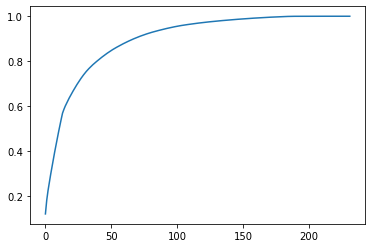

In [15]:
pca=PCA()
X_train_pca_df=pd.DataFrame(pca.fit_transform(X_train_final))

plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [17]:
pca_1=PCA(n_components=50)

X_train_pca_df=pd.DataFrame(pca_1.fit_transform(X_train_final),columns=list(range(0,50)))

X_test_pca_df=pd.DataFrame(pca_1.transform(X_test_final))

In [18]:
# Proof that PCA results in Zero or No Multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_pca = pd.DataFrame()
vif_pca["VIF Factor_PCA"] = [variance_inflation_factor(X_train_pca_df.values, i) for i in range(X_train_pca_df.shape[1])]

vif_pca['Column Name']=X_train_pca_df.columns

vif_pca

,VIF Factor_PCA,Column Name
0,1.0,0
1,1.0,1
2,1.0,2
3,1.0,3
4,1.0,4
5,1.0,5
6,1.0,6
7,1.0,7
8,1.0,8
9,1.0,9


# logistic Regression-PCA

In [19]:
logreg = LogisticRegression()
logreg.fit(X_train_pca_df,y_train)   #train the model on training data
print('train score =',logreg.score(X_train_pca_df,y_train))
print('test score =',logreg.score(X_test_pca_df,y_test))

train score = 0.8375
test score = 0.735


In [20]:
test_predictions = logreg.predict(X_test_pca_df)
test_predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [21]:
confusion_matrix(y_test,test_predictions)

array([[131,  18],
       [ 35,  16]], dtype=int64)

In [22]:
#test scores

print('precision score',precision_score(y_test,test_predictions))
print('recall score',recall_score(y_test,test_predictions))
print('test f1_score :',f1_score(y_test,test_predictions))

precision score 0.47058823529411764
recall score 0.3137254901960784
test f1_score : 0.3764705882352941


# logistic regression

In [26]:
logreg = LogisticRegression()
logreg.fit(X_train_final,y_train)   #train the model on training data
print('train score =',logreg.score(X_train_final,y_train))
print('test score =',logreg.score(X_test_final,y_test))

train score = 0.9175
test score = 0.805


In [27]:
test_predictions = logreg.predict(X_test_final)
test_predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [28]:
train_predictions = logreg.predict(X_train_final)
train_predictions

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [29]:
probability = logreg.predict_proba(X_test_final) 
pos_probability = logreg.predict_proba(X_test_final)[::,1]
probability

array([[9.88259838e-01, 1.17401616e-02],
       [6.11587597e-01, 3.88412403e-01],
       [7.95206312e-01, 2.04793688e-01],
       [9.67963569e-01, 3.20364308e-02],
       [1.06582074e-01, 8.93417926e-01],
       [6.06563422e-01, 3.93436578e-01],
       [8.46316459e-01, 1.53683541e-01],
       [8.56672964e-01, 1.43327036e-01],
       [7.52895789e-01, 2.47104211e-01],
       [1.40932453e-01, 8.59067547e-01],
       [5.23324032e-02, 9.47667597e-01],
       [9.96065789e-01, 3.93421068e-03],
       [9.69285665e-01, 3.07143355e-02],
       [9.73523051e-01, 2.64769488e-02],
       [8.36473622e-01, 1.63526378e-01],
       [8.72576248e-02, 9.12742375e-01],
       [9.13669871e-01, 8.63301291e-02],
       [3.04022094e-01, 6.95977906e-01],
       [8.59264332e-01, 1.40735668e-01],
       [9.83693418e-01, 1.63065824e-02],
       [8.70921007e-01, 1.29078993e-01],
       [9.52566864e-01, 4.74331364e-02],
       [9.53945240e-01, 4.60547599e-02],
       [3.47453107e-01, 6.52546893e-01],
       [5.715071

In [30]:
confusion_matrix(y_test,test_predictions)

array([[132,  17],
       [ 22,  29]], dtype=int64)

In [31]:
comparision_df = pd.DataFrame({'Actuals':y_test,'predictions':test_predictions})
comparision_df

,Actuals,predictions
632,0,0
687,0,0
833,0,0
182,0,0
831,1,1
...,...,...
258,0,0
118,0,0
279,0,0
458,0,0


In [32]:
#fpr,tpr,thresholds = roc_curve(y_test,pos_probability,pos_label='Y')
fpr,tpr,thresholds = roc_curve(y_test,pos_probability)

In [33]:
#test scores
#print('precision score',precision_score(y_test,test_predictions,pos_label='Y'))
print('precision score',precision_score(y_test,test_predictions))
print('recall score',recall_score(y_test,test_predictions))
print('test f1_score :',f1_score(y_test,test_predictions))

precision score 0.6304347826086957
recall score 0.5686274509803921
test f1_score : 0.5979381443298969


In [34]:
#train scores
print('precision score',precision_score(y_train,train_predictions))
print('recall score',recall_score(y_train,train_predictions))
print('train f1_score :',f1_score(y_train,train_predictions))

precision score 0.8651685393258427
recall score 0.7857142857142857
train f1_score : 0.8235294117647058


Text(0, 0.5, 'True Positive rate')

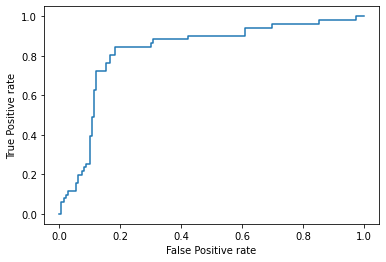

In [35]:
plt.plot(fpr,tpr)
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')

In [36]:
roc_auc_score(y_test,test_predictions)

0.7272667456244244

# Lasso Regularization

In [37]:
lasso = Lasso(alpha = 0.05)
lasso.fit(X_train_final,y_train)
lasso_coef_df = pd.DataFrame({'coefficients':lasso.coef_})
print('No. of variables which zero down:',len(lasso_coef_df[lasso_coef_df['coefficients']==0]))
lasso_coef_df


No. of variables which zero down: 231


,coefficients
0,0.0
1,0.0
2,-0.0
3,0.0
4,-0.0
...,...
227,0.0
228,-0.0
229,-0.0
230,0.0


# Ridge Regularization

In [38]:
ridge = Ridge(alpha = 1.0)
ridge.fit(X_train_final,y_train)
ridge_coef_df = pd.DataFrame({'coefficients':ridge.coef_})
len(ridge_coef_df[ridge_coef_df['coefficients']==0])
ridge_coef_df

,coefficients
0,0.004947
1,-0.012561
2,-0.015142
3,0.006474
4,0.001451
...,...
227,-0.007556
228,-0.016873
229,-0.098363
230,-0.127924


# Decision Tree Classifier

In [39]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train_final,y_train)
dt_predictions = dtc.predict(X_test_final)
dt_predictions

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [40]:
confusion_matrix(y_test,dt_predictions)

array([[127,  22],
       [ 24,  27]], dtype=int64)

In [41]:
print('decision tree precision score',precision_score(y_test,dt_predictions))
print('decision tree recall score',recall_score(y_test,dt_predictions))
print('decision tree f1_score :',f1_score(y_test,dt_predictions))
print('decision tree roc_auc_score',roc_auc_score(y_test,dt_predictions))

decision tree precision score 0.5510204081632653
decision tree recall score 0.5294117647058824
decision tree f1_score : 0.54
decision tree roc_auc_score 0.6908803789972364


# Random Forest Classifier

In [42]:
rfc = RandomForestClassifier()
rfc.fit(X_train_final,y_train)
rf_predictions = rfc.predict(X_test_final)
rf_predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [43]:
print('random_forest precision score',precision_score(y_test,rf_predictions))
print('random_forest recall score',recall_score(y_test,rf_predictions))
print('random_forest f1_score :',f1_score(y_test,rf_predictions))
print('random forest roc_auc_score',roc_auc_score(y_test,rf_predictions))

random_forest precision score 0.4827586206896552
random_forest recall score 0.27450980392156865
random_forest f1_score : 0.3500000000000001
random forest roc_auc_score 0.5869193314909856


# HyperParameter Tuning for Decision Tree

# GridSearch CV

In [44]:
hp_dtc_dict = {
               'max_depth':[5,6,7,8,9],
               'min_samples_split':[5,6,7,8,9],
               'max_leaf_nodes':[4,5,6,7,8],
               'min_samples_leaf':[6,7,8,9,10]
              }
gcv_dtc=GridSearchCV(dtc,hp_dtc_dict,cv=5,scoring='f1')
gcv_dtc.fit(X_train_final,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 6, 7, 8, 9],
                         'max_leaf_nodes': [4, 5, 6, 7, 8],
                         'min_samples_leaf': [6, 7, 8, 9, 10],
                         'min_samples_split': [5, 6, 7, 8, 9]},
             scoring='f1')

In [45]:
print('the best estimates for the parameters are ',gcv_dtc.best_estimator_)
print('the best score is ',gcv_dtc.best_score_)
print('the best parameters are ',gcv_dtc.best_params_)

the best estimates for the parameters are  DecisionTreeClassifier(max_depth=5, max_leaf_nodes=4, min_samples_leaf=6,
                       min_samples_split=5)
the best score is  0.7595474425042728
the best parameters are  {'max_depth': 5, 'max_leaf_nodes': 4, 'min_samples_leaf': 6, 'min_samples_split': 5}


In [46]:
gcv_dtc.predict(X_test_final)

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

# Randomized Search CV

In [47]:
rdcv_dtc=RandomizedSearchCV(dtc,hp_dtc_dict,cv=5,scoring='f1',n_iter=500)
rdcv_dtc.fit(X_train_final,y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=500,
                   param_distributions={'max_depth': [5, 6, 7, 8, 9],
                                        'max_leaf_nodes': [4, 5, 6, 7, 8],
                                        'min_samples_leaf': [6, 7, 8, 9, 10],
                                        'min_samples_split': [5, 6, 7, 8, 9]},
                   scoring='f1')

In [48]:
rdcv_dtc.predict(X_test_final)

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [49]:
print('the best estimates for the parameters are ',rdcv_dtc.best_estimator_)
print('the best score is ',rdcv_dtc.best_score_)
print('the best parameters are ',rdcv_dtc.best_params_)

the best estimates for the parameters are  DecisionTreeClassifier(max_depth=9, max_leaf_nodes=4, min_samples_leaf=7,
                       min_samples_split=9)
the best score is  0.7595474425042728
the best parameters are  {'min_samples_split': 9, 'min_samples_leaf': 7, 'max_leaf_nodes': 4, 'max_depth': 9}


# Hyperparameter Tuning Random Forest

# GridSearch CV

In [50]:
hp_rfc_dict= {
              'max_depth':[5,6,7,8],
               'min_samples_split':[6,7,8,9],
               'max_leaf_nodes':[5,6,7,8],
               'min_samples_leaf':[7,8,9,10],
               'n_estimators':[50,100,150,200]
             }
gcv_rfc = GridSearchCV(rfc,hp_rfc_dict,cv=4,scoring='f1')
gcv_rfc.fit(X_train_final,y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 6, 7, 8],
                         'max_leaf_nodes': [5, 6, 7, 8],
                         'min_samples_leaf': [7, 8, 9, 10],
                         'min_samples_split': [6, 7, 8, 9],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='f1')

In [51]:
print('the best estimates for the parameters are ',gcv_rfc.best_estimator_)
print('the best score is ',gcv_rfc.best_score_)
print('the best parameters are ',gcv_rfc.best_params_)

the best estimates for the parameters are  RandomForestClassifier(max_depth=6, max_leaf_nodes=8, min_samples_leaf=7,
                       min_samples_split=6, n_estimators=50)
the best score is  0.07767722473604825
the best parameters are  {'max_depth': 6, 'max_leaf_nodes': 8, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 50}


In [52]:
gcv_rfc.predict(X_test_final)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

# Randomizedsearch CV

In [53]:
rdcv_rfc= RandomizedSearchCV(rfc,hp_rfc_dict,cv=3,n_iter=500,scoring='f1')
rdcv_rfc.fit(X_train_final,y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=500,
                   param_distributions={'max_depth': [5, 6, 7, 8],
                                        'max_leaf_nodes': [5, 6, 7, 8],
                                        'min_samples_leaf': [7, 8, 9, 10],
                                        'min_samples_split': [6, 7, 8, 9],
                                        'n_estimators': [50, 100, 150, 200]},
                   scoring='f1')

In [54]:
rdcv_rfc.predict(X_test_final)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [55]:
print('the best estimates for the parameters are ',rdcv_rfc.best_estimator_)
print('the best score is ',rdcv_rfc.best_score_)
print('the best parameters are ',rdcv_rfc.best_params_)

the best estimates for the parameters are  RandomForestClassifier(max_depth=8, max_leaf_nodes=8, min_samples_leaf=9,
                       min_samples_split=6, n_estimators=50)
the best score is  0.06626425217974515
the best parameters are  {'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_leaf_nodes': 8, 'max_depth': 8}


# Adaboost Classifier

In [22]:
abc = AdaBoostClassifier()
abc.fit(X_train_final,y_train)
ab_predictions = abc.predict(X_test_final)
ab_predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [57]:
confusion_matrix(y_test,ab_predictions)

array([[127,  22],
       [ 24,  27]], dtype=int64)

In [31]:
print('Adaboost precision score',precision_score(y_test,ab_predictions))
print('Adaboost recall score',recall_score(y_test,ab_predictions))
print('Adaboost f1_score :',f1_score(y_test,ab_predictions))
print('Adaboost roc_auc_score',roc_auc_score(y_test,ab_predictions))

Adaboost precision score 0.5476190476190477
Adaboost recall score 0.45098039215686275
Adaboost f1_score : 0.49462365591397855
Adaboost roc_auc_score 0.6617318068166863


# Hyperparameter Tuning - Adaboost Classifier

# GridSearch CV

In [24]:
hp_abc_dict ={
              'n_estimators':[50,100,150],
              'learning_rate':[0.5,1.0,1.5]
            }
gcv_abc = GridSearchCV(abc,hp_abc_dict,cv=5,scoring = 'f1')
gcv_abc.fit(X_train_final,y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.5, 1.0, 1.5],
                         'n_estimators': [50, 100, 150]},
             scoring='f1')

In [68]:
gcv_abc.predict(X_test_final)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [69]:
print('the best estimates for the parameters are ',gcv_abc.best_estimator_)
print('f1 score is ',gcv_abc.best_score_)
print('the best parameters are ',gcv_abc.best_params_)

the best estimates for the parameters are  AdaBoostClassifier()
f1 score is  0.5768052640165316
the best parameters are  {'learning_rate': 1.0, 'n_estimators': 50}


# Randomized Search CV

In [25]:
rdcv_abc=RandomizedSearchCV(abc,hp_abc_dict,cv=3,scoring='f1',n_iter=100)
rdcv_abc.fit(X_train_final,y_train)

RandomizedSearchCV(cv=3, estimator=AdaBoostClassifier(), n_iter=100,
                   param_distributions={'learning_rate': [0.5, 1.0, 1.5],
                                        'n_estimators': [50, 100, 150]},
                   scoring='f1')

In [26]:
rdcv_abc.predict(X_test_final)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [27]:
print('the best estimates for the parameters are ',rdcv_abc.best_estimator_)
print('the best score is ',rdcv_abc.best_score_)
print('the best parameters are ',rdcv_abc.best_params_)

the best estimates for the parameters are  AdaBoostClassifier()
the best score is  0.5708390935663664
the best parameters are  {'n_estimators': 50, 'learning_rate': 1.0}


# GradientBoost Classifier

In [29]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_final,y_train)
gb_predictions = gbc.predict(X_test_final)
gb_predictions

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [30]:
confusion_matrix(y_test,gb_predictions)

array([[127,  22],
       [ 17,  34]], dtype=int64)

In [32]:
print('Gradient boost precision score',precision_score(y_test,gb_predictions))
print('Gradient boost recall score',recall_score(y_test,gb_predictions))
print('Gradient boost f1_score :',f1_score(y_test,gb_predictions))
print('Gradient boost roc_auc_score',roc_auc_score(y_test,gb_predictions))

Gradient boost precision score 0.6071428571428571
Gradient boost recall score 0.6666666666666666
Gradient boost f1_score : 0.6355140186915887
Gradient boost roc_auc_score 0.7595078299776286


# Hyperparameter Tuning- Gradient Boost

# Grid search CV

In [18]:
gbc = GradientBoostingClassifier()
hp_gbc_dict = {
               'max_depth':[5,6,7,8],
               'min_samples_split':[6,7,8,9],
               'max_leaf_nodes':[5,6,7,8],
               'min_samples_leaf':[7,8,9,10],
               'n_estimators':[50,100,150,200],
               'learning_rate':[0.1,0.2,0.3]
              }
gcv_gbc=GridSearchCV(gbc,hp_gbc_dict,cv=3,scoring='f1')
gcv_gbc.fit(X_train_final,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [5, 6, 7, 8],
                         'max_leaf_nodes': [5, 6, 7, 8],
                         'min_samples_leaf': [7, 8, 9, 10],
                         'min_samples_split': [6, 7, 8, 9],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='f1')

In [20]:
gcv_gbc.predict(X_test_final)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [21]:
print('the best estimates for the parameters are ',gcv_gbc.best_estimator_)
print('the f1 score is ',gcv_gbc.best_score_)
print('the best parameters are ',gcv_gbc.best_params_)

the best estimates for the parameters are  GradientBoostingClassifier(max_depth=5, max_leaf_nodes=5, min_samples_leaf=10,
                           min_samples_split=6, n_estimators=50)
the f1 score is  0.7131671947668302
the best parameters are  {'learning_rate': 0.1, 'max_depth': 5, 'max_leaf_nodes': 5, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 50}


# Randomized search CV

In [23]:
rdcv_gbc=RandomizedSearchCV(gbc,hp_gbc_dict,cv=3,scoring='f1',n_iter=100)
rdcv_gbc.fit(X_train_final,y_train)

RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=100,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3],
                                        'max_depth': [5, 6, 7, 8],
                                        'max_leaf_nodes': [5, 6, 7, 8],
                                        'min_samples_leaf': [7, 8, 9, 10],
                                        'min_samples_split': [6, 7, 8, 9],
                                        'n_estimators': [50, 100, 150, 200]},
                   scoring='f1')

In [24]:
rdcv_gbc.predict(X_test_final)

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [25]:
print('the best estimates for the parameters are ',rdcv_gbc.best_estimator_)
print('the f1 score is ',rdcv_gbc.best_score_)
print('the best parameters are ',rdcv_gbc.best_params_)

the best estimates for the parameters are  GradientBoostingClassifier(max_depth=7, max_leaf_nodes=5, min_samples_leaf=8,
                           min_samples_split=9, n_estimators=50)
the f1 score is  0.7122877515257718
the best parameters are  {'n_estimators': 50, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_leaf_nodes': 5, 'max_depth': 7, 'learning_rate': 0.1}


# support vector machine

In [ ]:
svm = SVC(C=1.0,kernel='linear')
svm.fit(X_train_final,y_train)
svm_predicts = svm.predict(X_test_final)
svm_predicts

In [16]:
confusion_matrix(y_test,svm_predicts)

array([[139,  10],
       [ 41,  10]], dtype=int64)

In [50]:
print('support vector machine precision score',precision_score(y_test,svm_predicts))
print('support vector machine recall score',recall_score(y_test,svm_predicts))
print('support vector machine f1_score :',f1_score(y_test,svm_predicts))
print('support vector machine roc_auc_score',roc_auc_score(y_test,svm_predicts))

support vector machine precision score 0.66
support vector machine recall score 0.6470588235294118
support vector machine f1_score : 0.6534653465346535
support vector machine roc_auc_score 0.7664824318989341


# Hyperparameter Tuning-SVM

# GridSearch CV

In [52]:
hp_svm_dict = {
               'C':[0.6,0.8,1.0],
               'kernel':['linear', 'poly', 'rbf', 'sigmoid']
              }
gcv_svm = GridSearchCV(svm,hp_svm_dict,cv=3,scoring='f1')
gcv_svm.fit(X_train_final,y_train)
svm_predicts = gcv_svm.predict(X_test_final)
svm_predicts

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [55]:
print('the best estimates for the parameters are ',gcv_svm.best_estimator_)
print('the f1 score is ',gcv_svm.best_score_)
print('the best parameters are ',gcv_svm.best_params_)

the best estimates for the parameters are  SVC(C=0.6, kernel='linear')
the f1 score is  0.6134925136626782
the best parameters are  {'C': 0.6, 'kernel': 'linear'}


# RandomizedSearchCV

In [53]:
rdcv_svm = RandomizedSearchCV(svm,hp_svm_dict,cv=3,scoring='f1',n_iter=100)
rdcv_svm.fit(X_train_final,y_train)
rdcv_svm.predict(X_test_final)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [56]:
print('the best estimates for the parameters are ',rdcv_svm.best_estimator_)
print('the f1 score is ',rdcv_svm.best_score_)
print('the best parameters are ',rdcv_svm.best_params_)

the best estimates for the parameters are  SVC(C=0.6, kernel='linear')
the f1 score is  0.6134925136626782
the best parameters are  {'kernel': 'linear', 'C': 0.6}
